In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/AV/collision_risk_dataset.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
print(df.describe())

# Check class distribution
print("\nClass distribution:")
print(df['risk'].value_counts())
print(f"\nPercentage of positive class: {df['risk'].mean()*100:.2f}%")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             500 non-null    float64
 1   speed            500 non-null    float64
 2   steer_angle      500 non-null    float64
 3   accel            500 non-null    float64
 4   distance_to_obj  500 non-null    float64
 5   rel_speed        500 non-null    float64
 6   brake            500 non-null    float64
 7   weather          500 non-null    int64  
 8   road_type        500 non-null    int64  
 9   risk             500 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 39.2 KB
None

First 5 rows:
   time      speed  steer_angle     accel  distance_to_obj  rel_speed  \
0   0.0  54.967142     4.630888  2.798711         9.433956 -20.708762   
1   0.2  48.617357     9.547083  1.849267        52.297551 -16.267675   
2   0.4  56.476885    -6.992838  0.1192

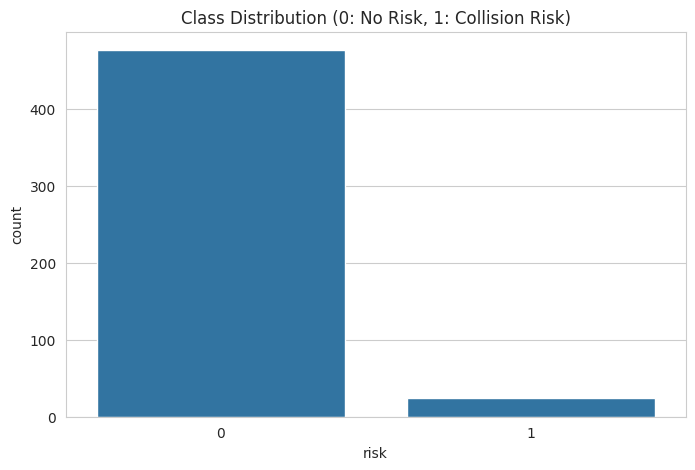

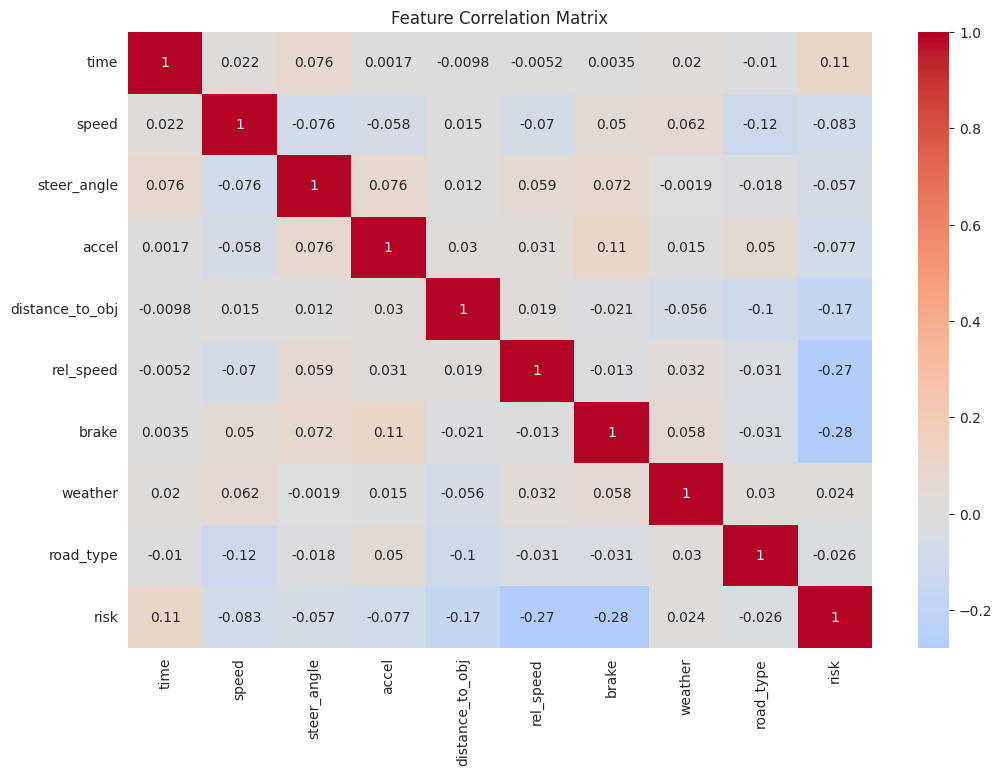

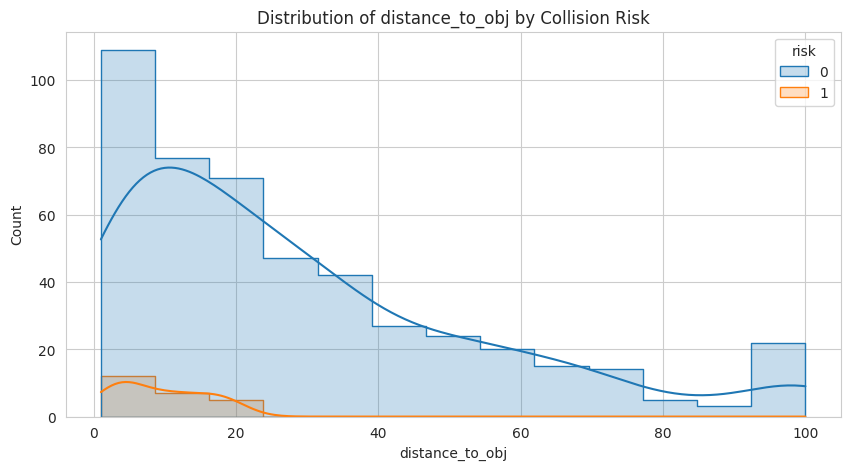

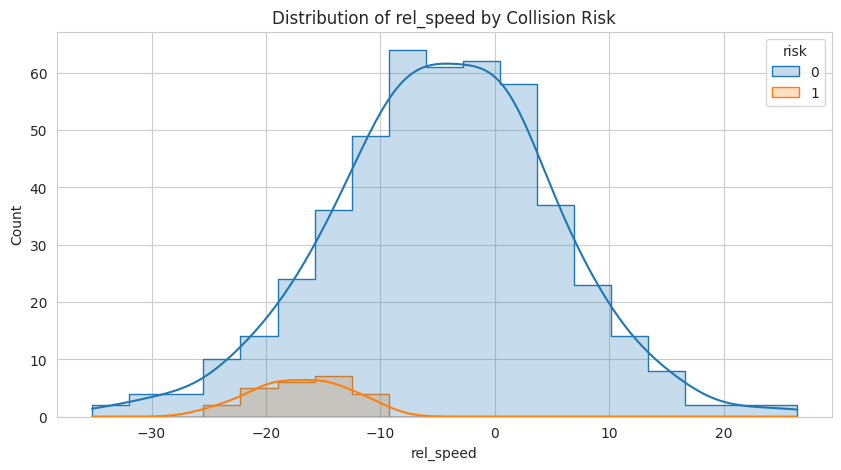

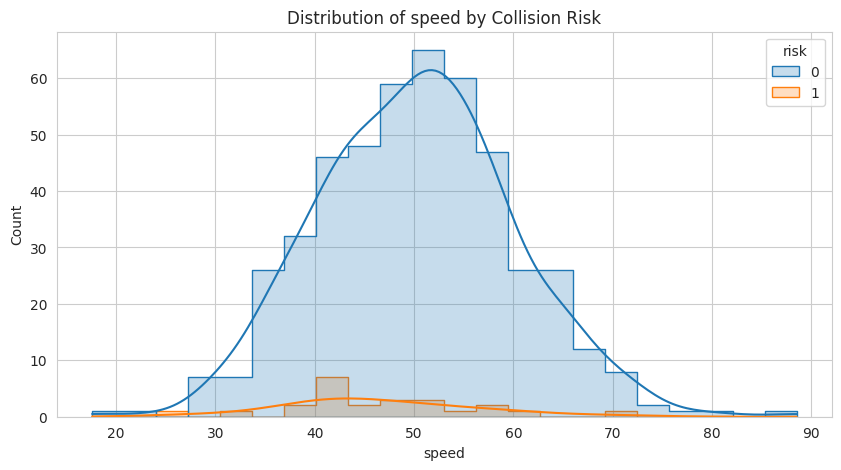

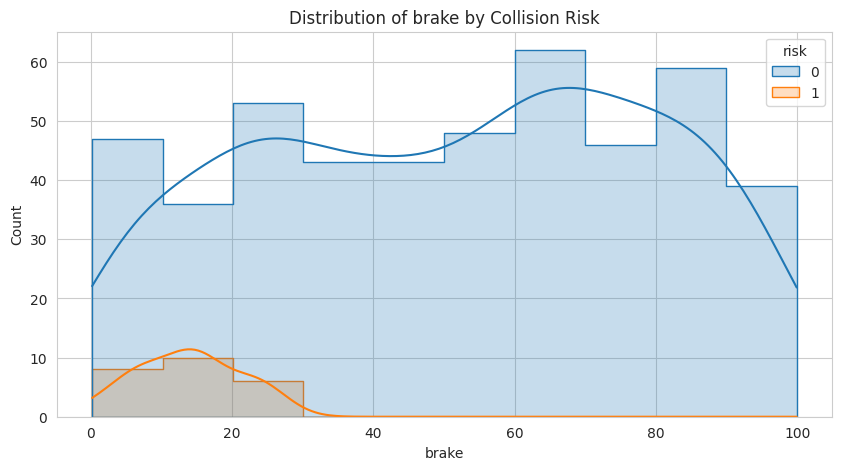

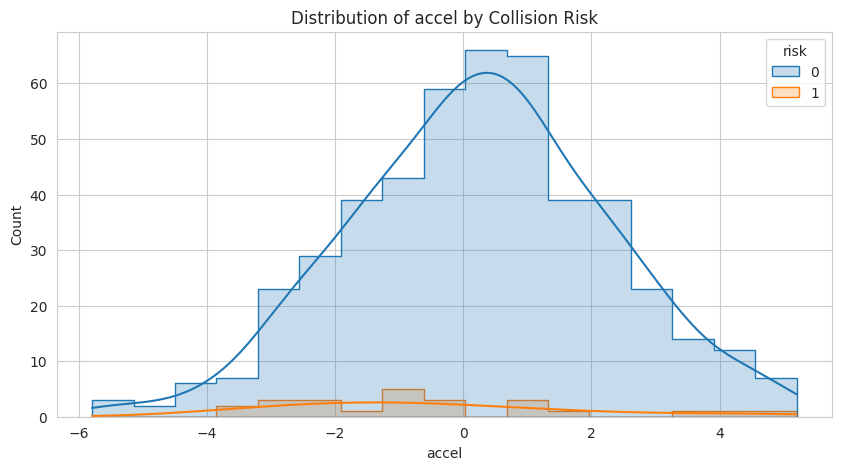

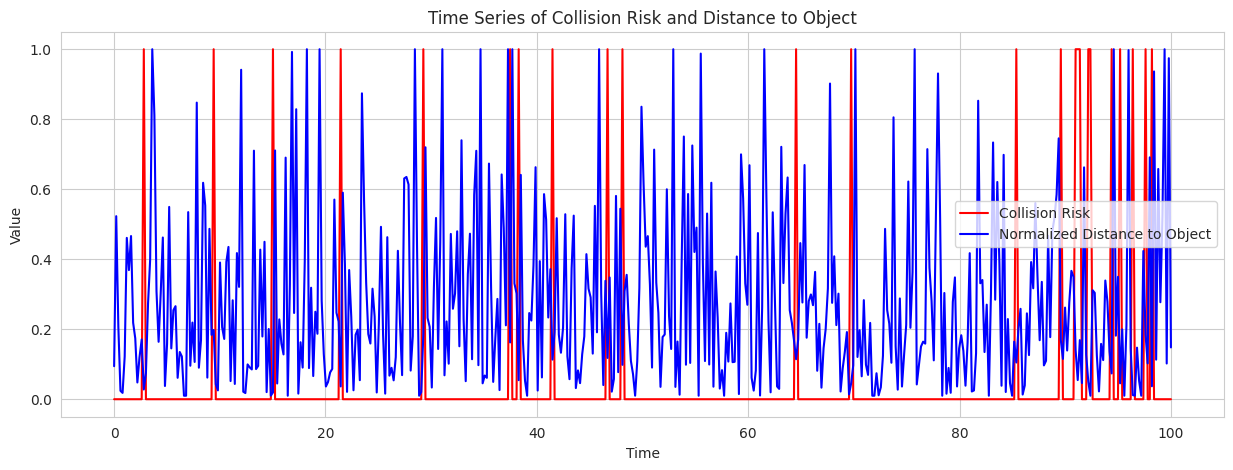

In [4]:
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='risk', data=df)
plt.title('Class Distribution (0: No Risk, 1: Collision Risk)')
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Plot distributions of key features
features_to_plot = ['distance_to_obj', 'rel_speed', 'speed', 'brake', 'accel']
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=feature, hue='risk', kde=True, element='step')
    plt.title(f'Distribution of {feature} by Collision Risk')
    plt.show()

# Plot time series of risk events
plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['risk'], 'r-', label='Collision Risk')
plt.plot(df['time'], df['distance_to_obj']/df['distance_to_obj'].max(), 'b-', label='Normalized Distance to Object')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series of Collision Risk and Distance to Object')
plt.legend()
plt.show()

In [5]:
# Handle class imbalance using SMOTE
X = df.drop(['risk', 'time'], axis=1)
y = df['risk']

# Split data before applying SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Resampled class distribution:")
print(pd.Series(y_train_res).value_counts())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

Resampled class distribution:
risk
0    333
1    333
Name: count, dtype: int64


In [6]:
# Create interaction features that might be relevant
def add_interaction_features(df):
    df['speed_distance_ratio'] = df['speed'] / (df['distance_to_obj'] + 1e-5)
    df['brake_accel_ratio'] = df['brake'] / (abs(df['accel']) + 1e-5)
    df['rel_speed_distance'] = df['rel_speed'] * df['distance_to_obj']
    df['speed_steer_interaction'] = df['speed'] * abs(df['steer_angle'])
    return df

# Apply to both training and test sets
X_train_features = pd.DataFrame(X_train_res, columns=X.columns)
X_train_features = add_interaction_features(X_train_features)

X_test_features = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_features = add_interaction_features(X_test_features)

# Update scaled data with new features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_features)
X_test_final = scaler.transform(X_test_features)

# Display new features
print("\nNew features added:")
print(X_train_features[['speed_distance_ratio', 'brake_accel_ratio',
                       'rel_speed_distance', 'speed_steer_interaction']].head())


New features added:
   speed_distance_ratio  brake_accel_ratio  rel_speed_distance  \
0             15.701989          11.579523          -32.643159   
1              2.147040          24.967805         -172.988862   
2              1.114071         230.780378         -420.391197   
3              3.248750         523.283945         -269.306958   
4              1.131916          33.503864         -193.919370   

   speed_steer_interaction  
0               485.396538  
1               128.208924  
2               428.836495  
3               202.201664  
4                24.143012  


In [7]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_final, y_train_res)
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Find best model based on F1 score
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Model Performance Comparison:
                     accuracy  precision    recall        f1   roc_auc
Random Forest        0.953333   0.000000  0.000000  0.000000  0.448551
Gradient Boosting    0.953333   0.000000  0.000000  0.000000  0.500000
Logistic Regression  0.173333   0.046512  0.857143  0.088235  0.541459
SVM                  0.953333   0.000000  0.000000  0.000000  0.674326

Best model: Logistic Regression


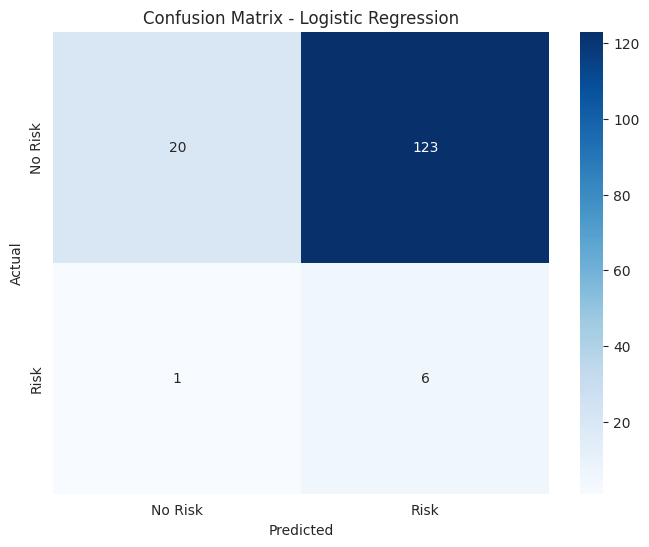


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.14      0.24       143
           1       0.05      0.86      0.09         7

    accuracy                           0.17       150
   macro avg       0.50      0.50      0.17       150
weighted avg       0.91      0.17      0.24       150



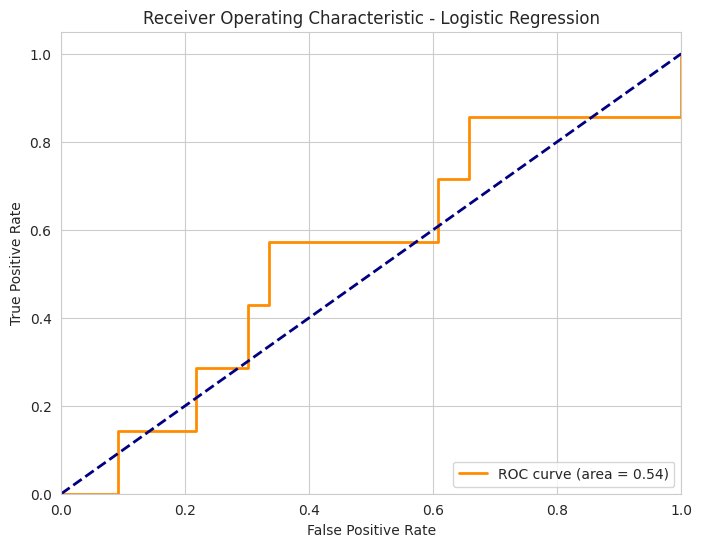

In [8]:
# Detailed evaluation of best model
y_pred_best = best_model.predict(X_test_final)
y_prob_best = best_model.predict_proba(X_test_final)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'],
            yticklabels=['No Risk', 'Risk'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

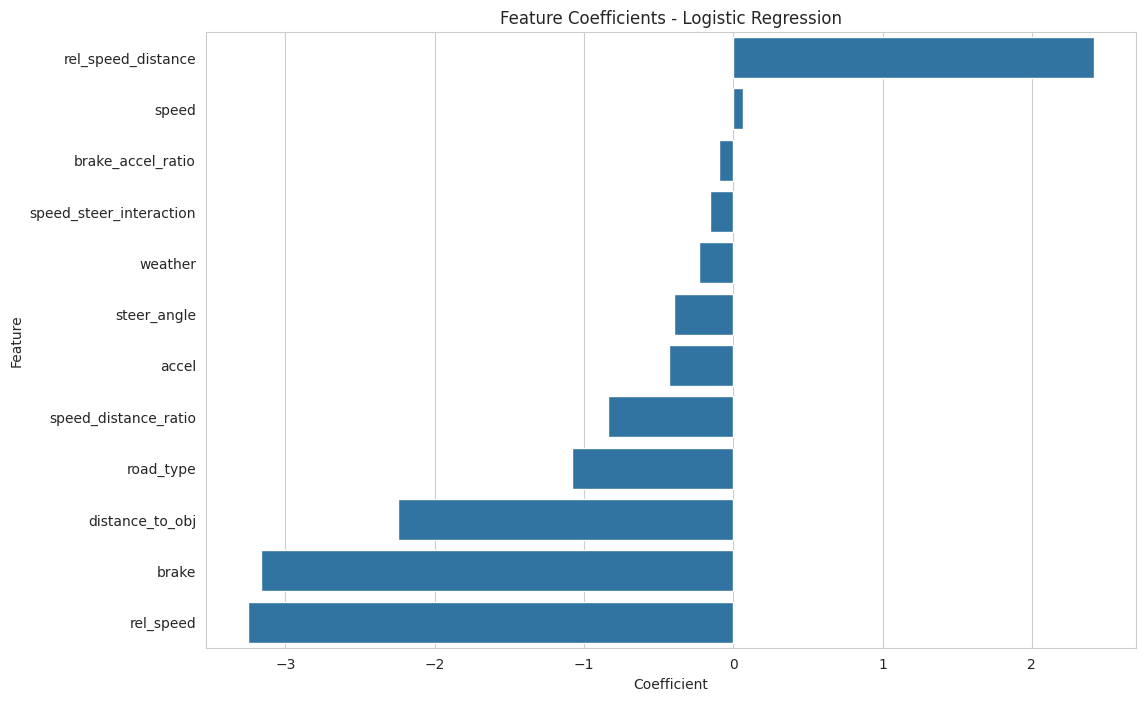


Top 10 Positive/Negative Coefficients:
                    Feature  Coefficient
10       rel_speed_distance     2.413049
0                     speed     0.062156
9         brake_accel_ratio    -0.097059
11  speed_steer_interaction    -0.155901
6                   weather    -0.228422
8      speed_distance_ratio    -0.840782
7                 road_type    -1.080659
3           distance_to_obj    -2.246570
5                     brake    -3.161727
4                 rel_speed    -3.250106


In [9]:
# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = X_train_features.columns
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()

    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))
elif hasattr(best_model, 'coef_'):
    coefficients = best_model.coef_[0]
    features = X_train_features.columns
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.show()

    print("\nTop 10 Positive/Negative Coefficients:")
    print(pd.concat([coef_df.head(5), coef_df.tail(5)]))

In [10]:
# Hyperparameter tuning for the best model
if isinstance(best_model, RandomForestClassifier):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif isinstance(best_model, GradientBoostingClassifier):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5]
    }
elif isinstance(best_model, LogisticRegression):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
elif isinstance(best_model, SVC):
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01],
        'kernel': ['rbf']
    }

# Perform grid search
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_final, y_train_res)

# Get best model
tuned_model = grid_search.best_estimator_

# Evaluate tuned model
y_pred_tuned = tuned_model.predict(X_test_final)
y_prob_tuned = tuned_model.predict_proba(X_test_final)[:, 1]

print("\nBest Parameters:")
print(grid_search.best_params_)
print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_tuned):.4f}")


Best Parameters:
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.41      0.58       143
           1       0.06      0.71      0.10         7

    accuracy                           0.43       150
   macro avg       0.51      0.56      0.34       150
weighted avg       0.92      0.43      0.56       150

ROC AUC Score: 0.5544



Real-time Prediction Simulation Results:
      time  distance_to_obj  rel_speed      speed      brake  risk  \
161  32.26        30.201436  -6.342792  57.870846  89.085553     0   
103  20.64         8.669154   4.375701  41.977227  10.539322     0   
381  76.35        15.054791  -7.515389  44.006074  64.950893     0   
141  28.26        18.002787  -5.093003  63.071428  83.790837     0   
129  25.85        46.292403  22.596600  44.965243  32.674254     0   
81   16.23        69.027598   0.161783  53.571126  36.844892     0   
398  79.76         3.647666  14.956675  48.854602  63.594033     0   
376  75.35        20.409688   6.941094  58.723206  34.190528     0   
464  92.99        12.492938  -6.558982  48.876720  96.776147     0   
291  58.32        27.365786  -4.808522  45.069991   7.697167     0   
204  40.88        51.288276 -10.441140  36.223306  62.842646     0   
261  52.30        59.977596 -17.575779  49.404746  75.174699     0   
138  27.66        63.503552 -13.224199  58.13517

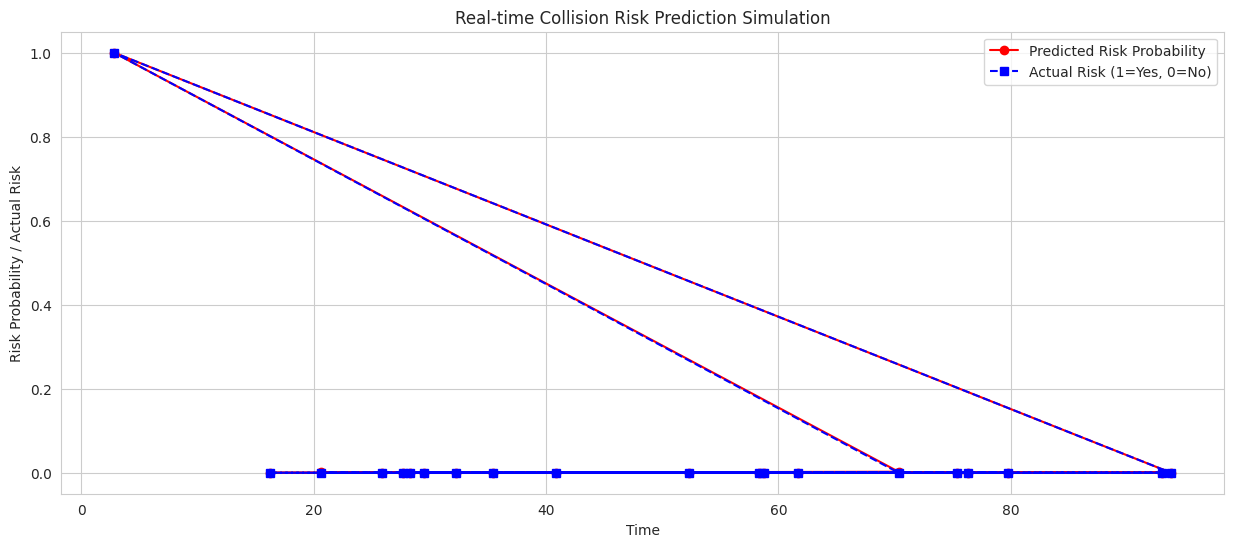

In [11]:
# Function to simulate real-time predictions
def simulate_real_time_predictions(model, scaler, original_df, num_samples=20):
    # Get sample data points
    sample_indices = np.random.choice(original_df.index, num_samples, replace=False)
    samples = original_df.iloc[sample_indices].copy()

    # Prepare features
    X_sample = samples.drop(['risk', 'time'], axis=1)
    X_sample_features = add_interaction_features(X_sample)
    X_sample_scaled = scaler.transform(X_sample_features)

    # Make predictions
    predictions = model.predict(X_sample_scaled)
    probabilities = model.predict_proba(X_sample_scaled)[:, 1]

    # Add to results
    results = samples[['time', 'distance_to_obj', 'rel_speed', 'speed', 'brake', 'risk']].copy()
    results['predicted_risk'] = predictions
    results['risk_probability'] = probabilities

    return results

# Run simulation
simulation_results = simulate_real_time_predictions(tuned_model, scaler, df)
print("\nReal-time Prediction Simulation Results:")
print(simulation_results)

# Visualize some simulation results
plt.figure(figsize=(15, 6))
plt.plot(simulation_results['time'], simulation_results['risk_probability'], 'ro-', label='Predicted Risk Probability')
plt.plot(simulation_results['time'], simulation_results['risk'], 'bs--', label='Actual Risk (1=Yes, 0=No)')
plt.xlabel('Time')
plt.ylabel('Risk Probability / Actual Risk')
plt.title('Real-time Collision Risk Prediction Simulation')
plt.legend()
plt.show()

In [12]:
import joblib

# Save the trained model and scaler
model_filename = 'collision_risk_model.pkl'
scaler_filename = 'collision_risk_scaler.pkl'
joblib.dump(tuned_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"Model saved as {model_filename}")
print(f"Scaler saved as {scaler_filename}")

# Function to load and use the model for new predictions
def predict_collision_risk(new_data, model_path=model_filename, scaler_path=scaler_filename):
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # Add interaction features
    new_data_features = add_interaction_features(new_data)

    # Scale features
    new_data_scaled = scaler.transform(new_data_features)

    # Make prediction
    prediction = model.predict(new_data_scaled)
    probability = model.predict_proba(new_data_scaled)[:, 1]

    return prediction, probability

# Test the prediction function
sample_data = df.drop(['risk', 'time'], axis=1).iloc[:5]
prediction, probability = predict_collision_risk(sample_data)
print("\nSample Predictions:")
print("Predicted Risk:", prediction)
print("Risk Probability:", probability)

Model saved as collision_risk_model.pkl
Scaler saved as collision_risk_scaler.pkl

Sample Predictions:
Predicted Risk: [0 0 1 0 0]
Risk Probability: [8.39647189e-03 7.16398028e-15 8.10816841e-01 5.31325660e-12
 1.50725250e-10]
